In [3]:
import numpy as np
from pathlib import Path
import spatialdata_io
import spatialdata
import json
import time
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
from joblib import Parallel, delayed

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
from QC import QC
import coexpression
import readwrite
cfg = readwrite.config()

def read_cc_file(k, method, target_count, results_dir):
    """
    Worker function to read Parquet files for a specific method and target count.
    """
    out_file_coexpr = results_dir / f'coexpression/{"/".join(k)}/coexpression_{method}_{target_count}.parquet'
    out_file_pos_rate = results_dir / f'coexpression/{"/".join(k)}/positivity_rate_{method}_{target_count}.parquet'
    
    cc = pd.read_parquet(out_file_coexpr)
    pos_rate = pd.read_parquet(out_file_pos_rate)[0]
    return method, target_count, cc, pos_rate


def read_cc_files(cc_paths, results_dir):

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(read_cc_file, k, method, target_count, results_dir)
            for k, method, target_count in cc_paths
        ]

        CC = {}
        pos_rate = {}
        for future in concurrent.futures.as_completed(futures):
            method, target_count, cc, pr = future.result()
            k = cc_paths[futures.index(future)][0]  # Retrieve the `k` corresponding to this future
            
            if k not in CC:
                CC[k] = {}
            if k not in pos_rate:
                pos_rate[k] = {}

            CC[k][method, target_count] = cc
            pos_rate[k][method, target_count] = pr
    return CC, pos_rate

## Load data

In [2]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}
# dir_segmentations['default'] = xenium_raw_data_dir

# Params
# SEGMENTATIONS = list(dir_segmentations.keys())
# COHORTS = [p.stem for p in xenium_raw_data_dir.iterdir() if p.is_dir()]
# COHORTS_PANELS = {cohort: [p.stem for p in (xenium_raw_data_dir / cohort).iterdir()] for cohort in COHORTS}
# COHORTS_SAMPLES = {(cohort,panel): 
#                         [replicate.stem 
#                         for sample in (xenium_raw_data_dir / cohort / panel).iterdir()
#                         for replicate in sample.iterdir()
#                         if 'corrupt' not in replicate.name and 'output' not in replicate.name and replicate.is_dir()] 
#                     for cohort in COHORTS 
#                     for panel in COHORTS_PANELS[cohort]}


# Read resegmentations and RCTD
# Coexpression params
methods = ['conditional','jaccard','pearson','spearman']
target_counts = [30,50]

xenium_paths = {}
cc_paths = []

for segmentation in (segmentations := xenium_dir.iterdir()):
    for cohort in (cohorts := segmentation.iterdir()): 
        for panel in (panels := cohort.iterdir()):
            for sample in (samples := panel.iterdir()):
                for replicate in (replicates := sample.iterdir()):
                    
                    k = (segmentation.stem,cohort.stem,panel.stem,sample.stem,replicate.stem)
                    replicate_path = replicate / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = replicate_path

                    if replicate_path.exists():

                        for method in methods:
                            for target_count in target_counts:
                                cc_paths.append((k, method, target_count))


# CC, pos_rate = read_cc_files(cc_paths, results_dir)
xenium_levels = ('segmentation','cohort','panel','sample','replicate')
ads = readwrite.read_xenium_samples(xenium_paths,anndata_only=True,transcripts=False,sample_name_as_key=False)
ads = pd.Series(ads.values(),
                index=pd.Index(ads.keys(),name = xenium_levels),
                dtype=object).sort_index()

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/lun
         g/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg_v1/breast
         /breast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                        
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg_v1/breast
         /breast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_0um/NSCLC
         /5k/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_0um/NSCLC
         /5k/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_0um/NSCLC
         /5k/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_0um/NSCLC
         /5k/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/19TB/19TB/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/breast/b
         reast/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5    

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1G73/1G73_1/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1G73/1G73_2/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/lu
         ng/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                         
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                         
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/19TB/19TB/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/breast/
         breast/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1G73/1G73_1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1G73/1G73_2/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GFF/1GFF/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5   

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/l
         ung/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/c
         huvio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_15um/NSCLC/5
         k/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5     

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                              


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                           


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/19TB/19TB/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/breast/br
         east/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5     

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/lun
         g/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/chu
         vio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                              
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/
         0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                  


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/
         1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                  
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/
         1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                  
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/
         1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5       

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/breast/br
         east/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lun
         g/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1FYB/1FYB/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_3/normalised_results/outs/cell_feature_matrix.h5                                          


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_1/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/OPHI/OPHI_2/normalised_results/outs/cell_feature_matrix.h5                                          
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1BCA/1BCA/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0PD6/0PD6/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1256/1256/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1GV1/1GV1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1GVR/1GVR/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1FHZ/1FHZ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0U9A/0U9A/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1ESQ/1ESQ/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0VRA/0VRA/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/14LZ/14LZ/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1H27/1H27/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1GUC/1GUC/normalised_results/outs/cell_feature_matrix.h5 

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                            
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/19TB/19TB/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/1FO7/1FO7/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0S8R/0S8R/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1G73/1G73_1/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1G73/1G73_2/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5    

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                               
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/lu
         ng/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/0PSV/0PSV_1/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/0PSV/0PSV_2/normalised_results/outs/cell_feature_matrix.h5

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/ch
         uvio/0WMU/0WMU/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                 
Error processing [Errno 2] No such file or directory: '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/baysor/NSCLC/5k/1G73/1G73/normalised_results/outs/experiment.xenium'
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/NSCLC/5k
         /1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                 
INFO     reading                                                                          

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_15um/NSCL
         C/5k/1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_15um/NSCL
         C/5k/1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_15um/NSCL
         C/5k/1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_15um/NSCL
         C/5k/1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                             


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

In [36]:
ad_5k = ads.loc['10x_0um','NSCLC','5k','0PSV','0PSV']
ad_lung = ads.loc['10x_0um','NSCLC','lung','0PSV','0PSV']

ad_5k = ads.loc['10x_0um','NSCLC','5k','1G73','1G73']
ad_lung = ads.loc['10x_0um','NSCLC','lung','1G73','1G73_1']
ad_chuvio = ads.loc['10x_0um','NSCLC','chuvio','1G73','1G73']

<Axes: >

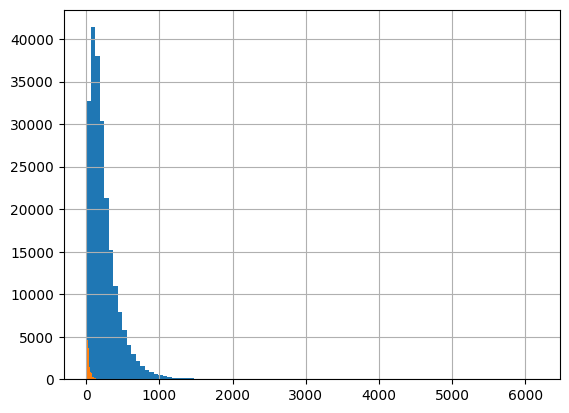

In [37]:
ad_5k.obs['transcript_counts'].hist(bins=100)
ad_lung.obs['transcript_counts'].hist(bins=100)

In [38]:
ad_5k.obs['transcript_counts'].mean(),ad_lung.obs['transcript_counts'].mean()

(236.50799504070451, 26.120522304187016)

In [39]:
ad_5k.obs['transcript_counts'].median(),ad_lung.obs['transcript_counts'].median()

(180.0, 18.0)

## General QC

In [5]:
# for name,f in all_files.items():
#     if pathlib.Path(cfg['figures_dir']+f'xenium/QC/{name}.png').exists():
#         print('skipping',name,f)
#         continue
#     else:
#         # try:
#         # sd = readwrite.read_xenium_samples({name:f},anndata_only=False,transcripts=True)[name]
#         QC(sd,name,cfg['figures_dir']+f'xenium/QC/{name}.png')
#         %xdel sd
#         # except:
#         #     print('failed',name,f)

In [6]:
# failed_samples = ['1G4Y', '1G11']
# for name,f in all_files.items():
#     if name.split('-')[2] in failed_samples:
#         print(name)
#         sd = readwrite.read_xenium({name:f},anndata_only=False,transcripts=True)[name]

## Coexpression

### Find spurious genes as in proseg paper

In [7]:
# Coexpression params
min_positivity_rate = 0.01
cc_cutoff = 1.5
log2 = False
ref_segmentation = '10x_0um'

CCdiff = {}
spurious_gene_pairs = {}
for k in CC.keys():
    if k[0] == ref_segmentation:
        continue

    CCdiff[k] = {}
    spurious_gene_pairs[k] = {}
    for m in methods:
        for t in target_counts:
            k_ref = (ref_segmentation,*k[1:])

            (CCdiff[k][m,t], 
            spurious_gene_pairs[k][m,t]) = coexpression.compare_segmentations(
                                CC_ref_seg = CC[k_ref][m,t], 
                                CC_other_seg = CC[k][m,t], 
                                pos_rate_ref_seg=pos_rate[k_ref][m,t], 
                                pos_rate_other_seg=pos_rate[k][m,t], 
                                min_positivity_rate=min_positivity_rate, 
                                cc_cutoff = cc_cutoff,
                                method=m, log2=log2)

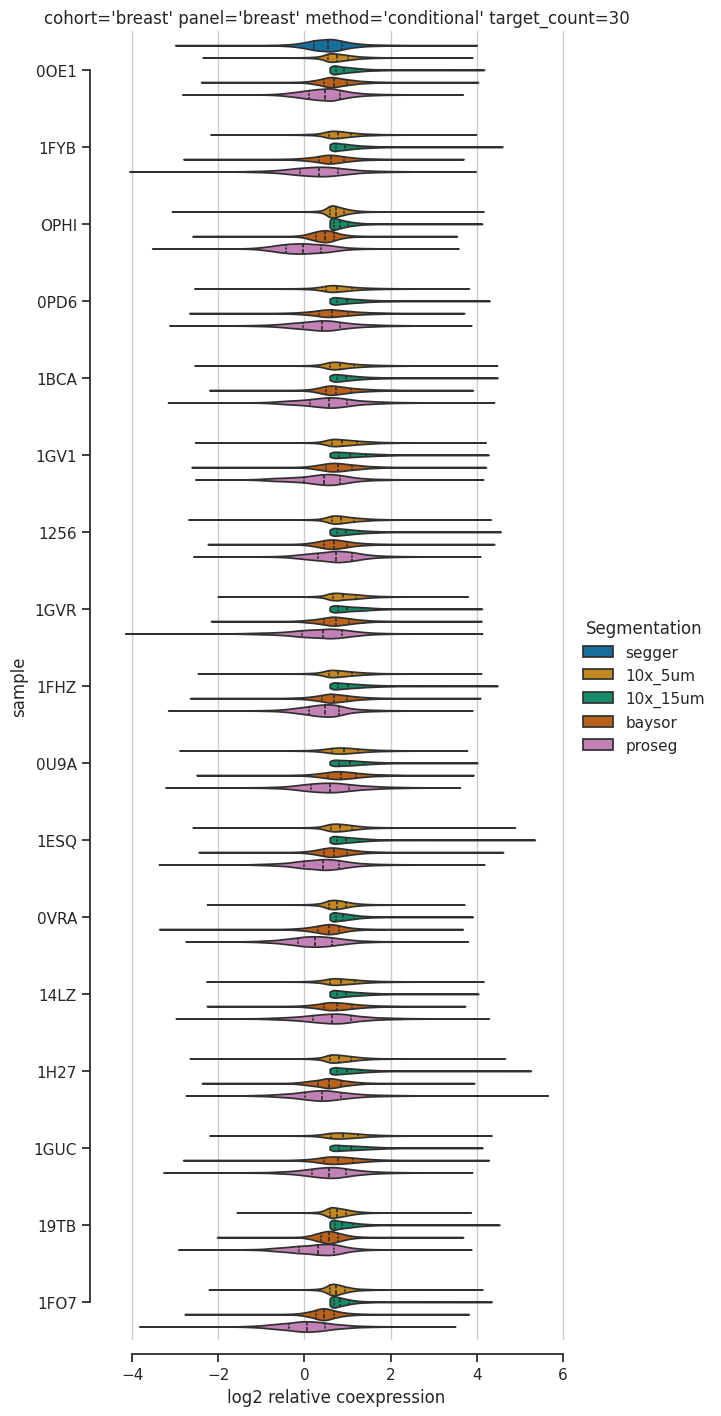

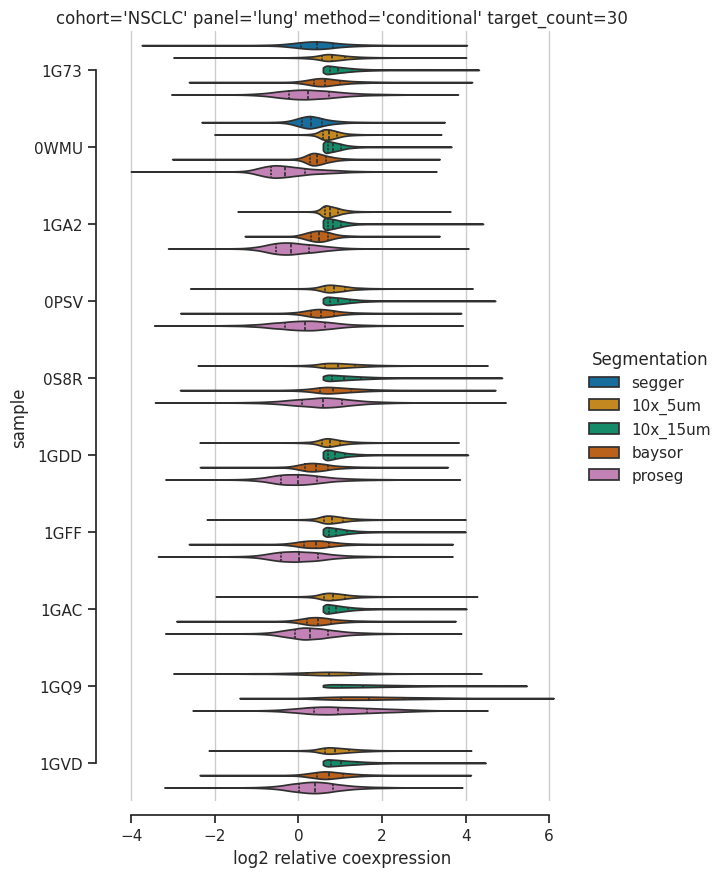

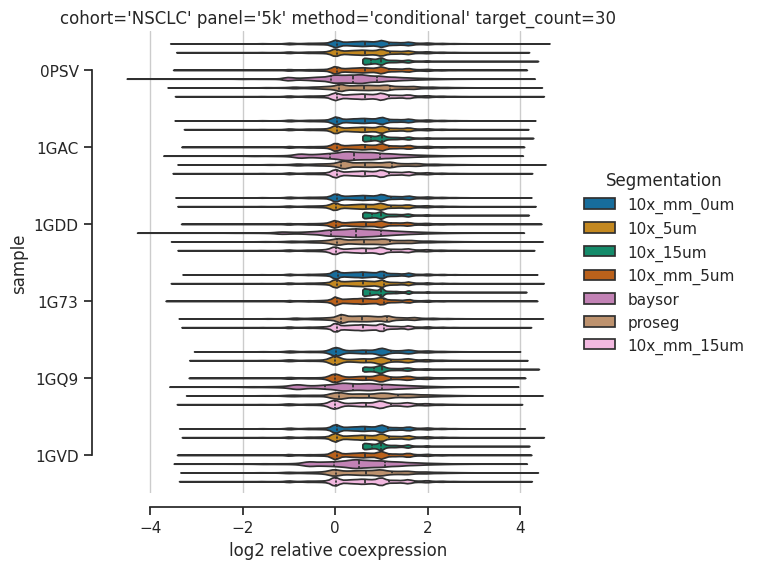

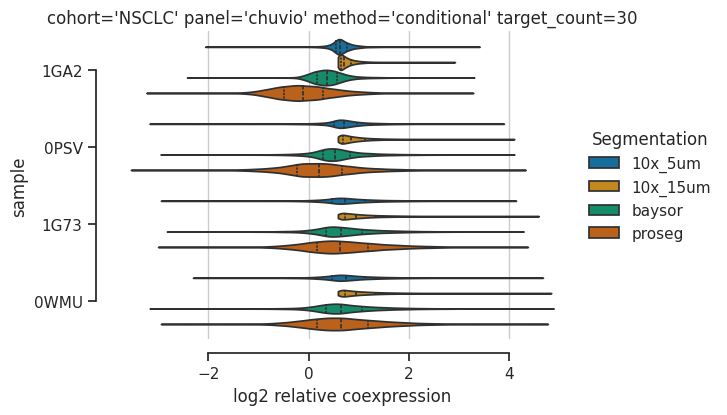

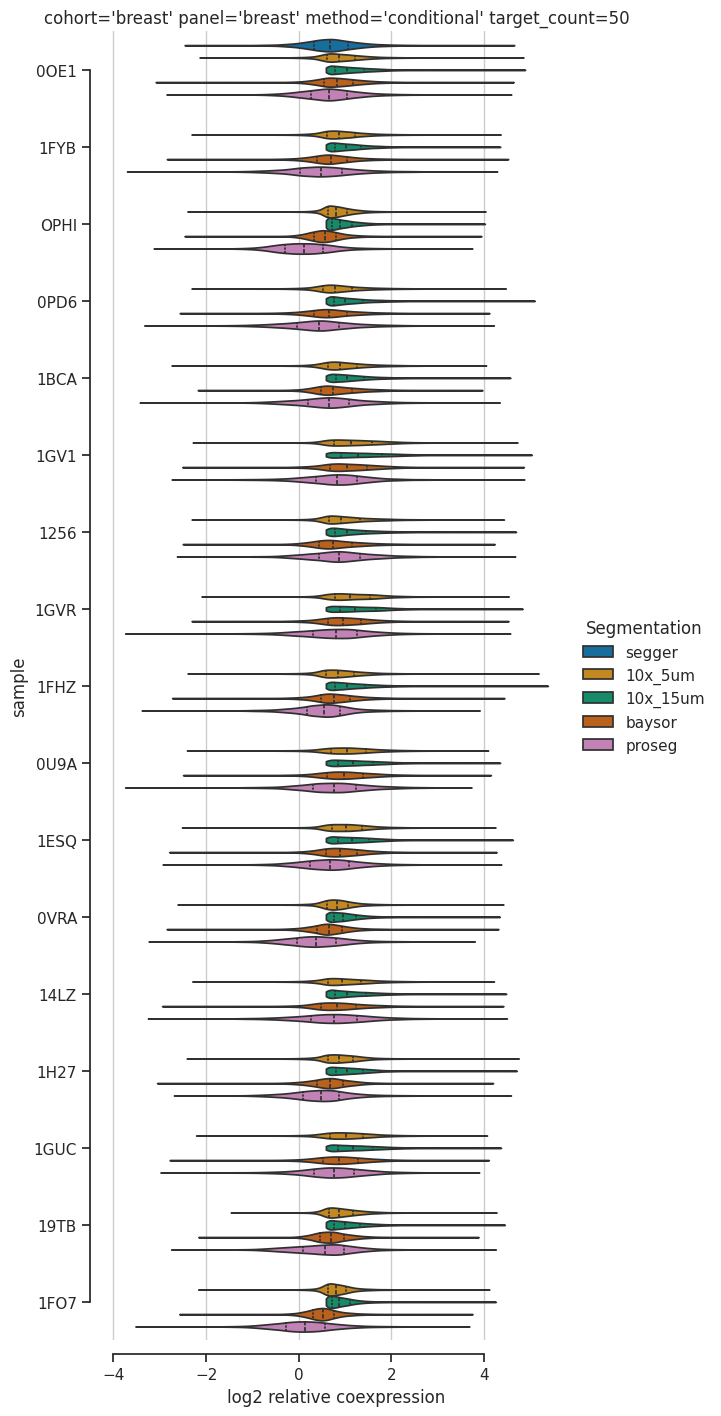

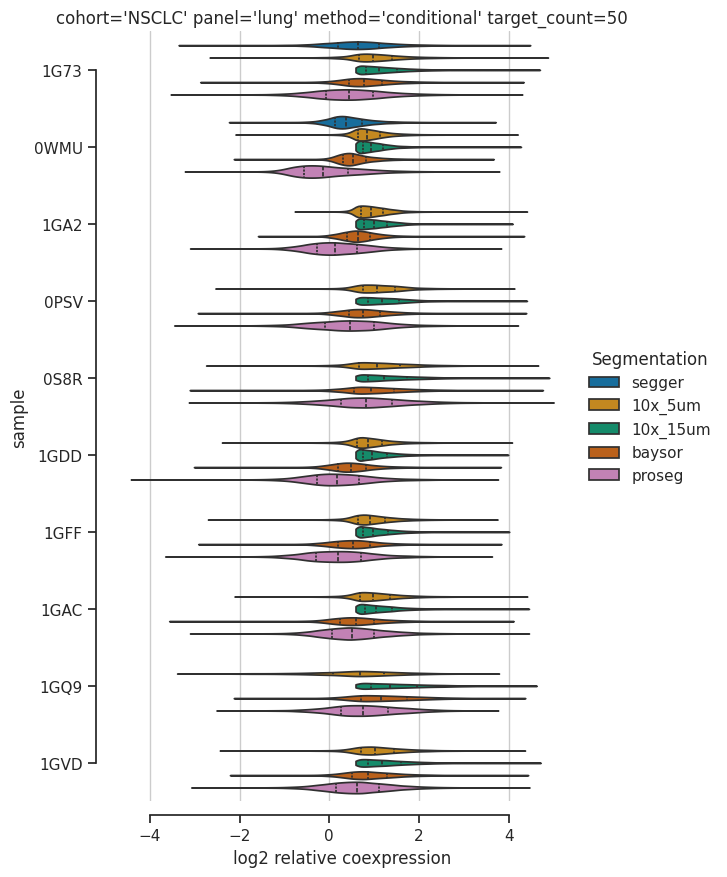

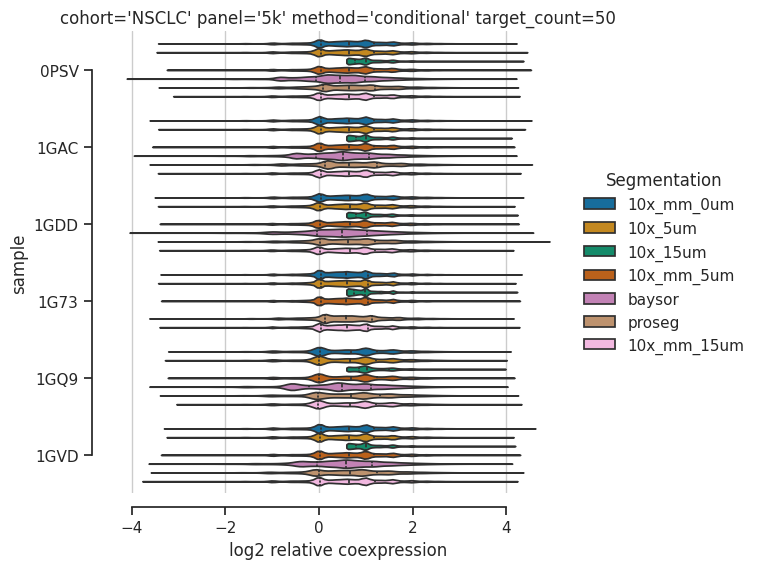

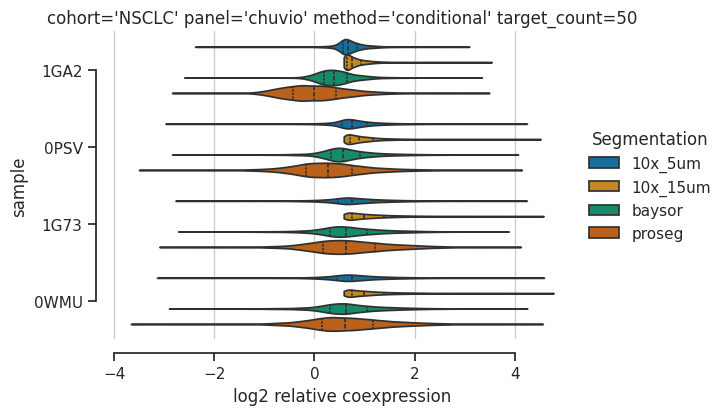

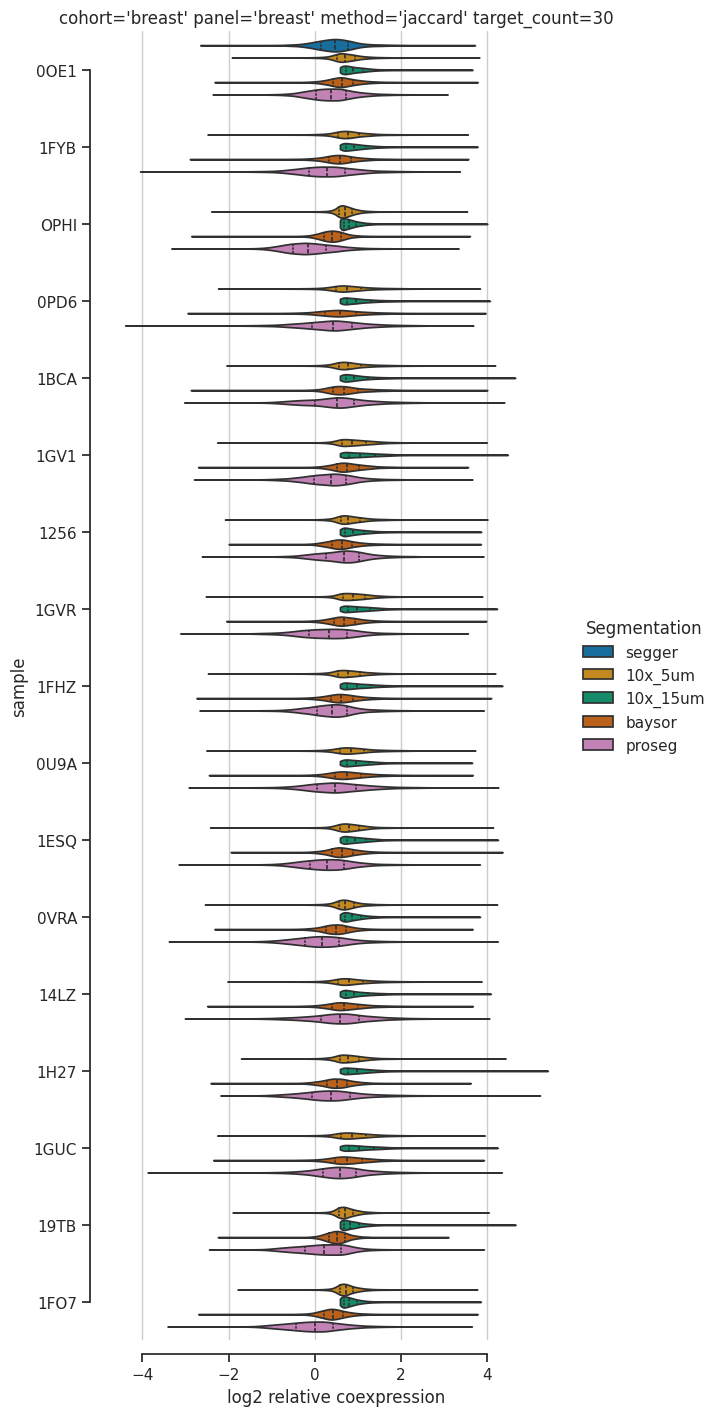

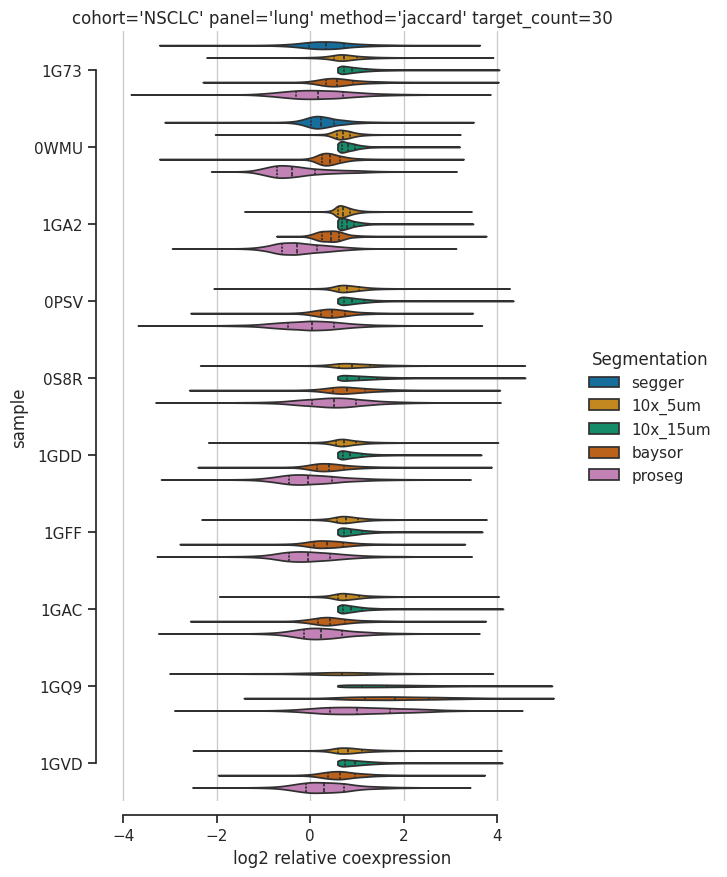

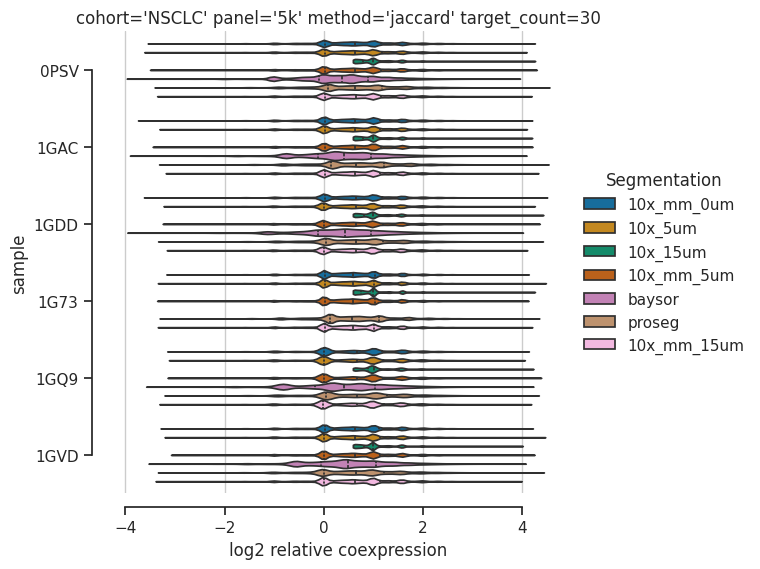

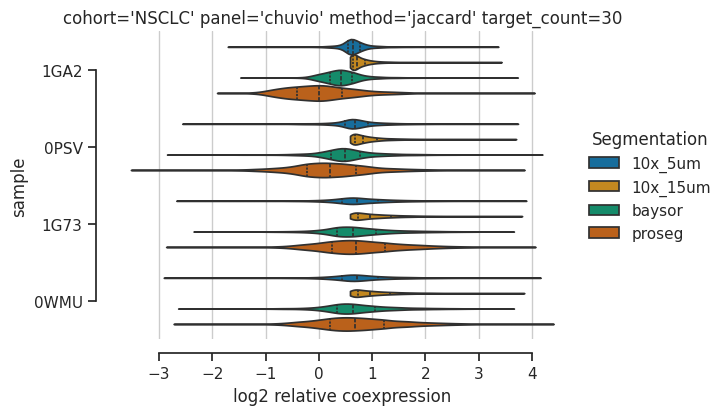

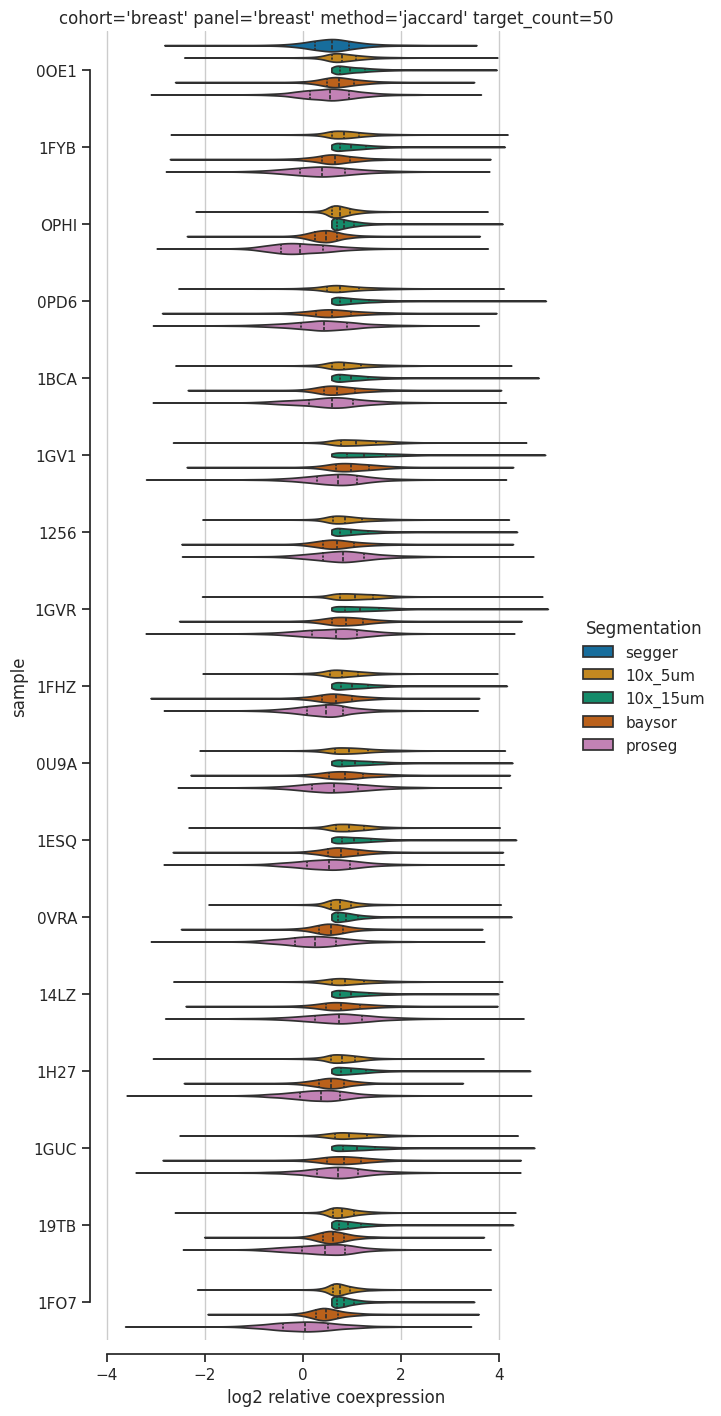

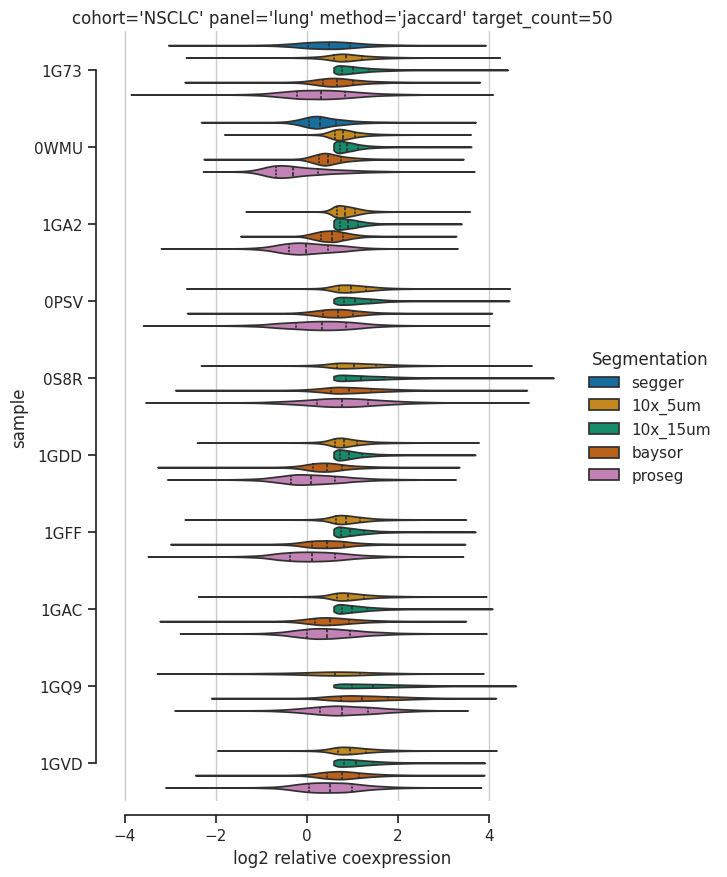

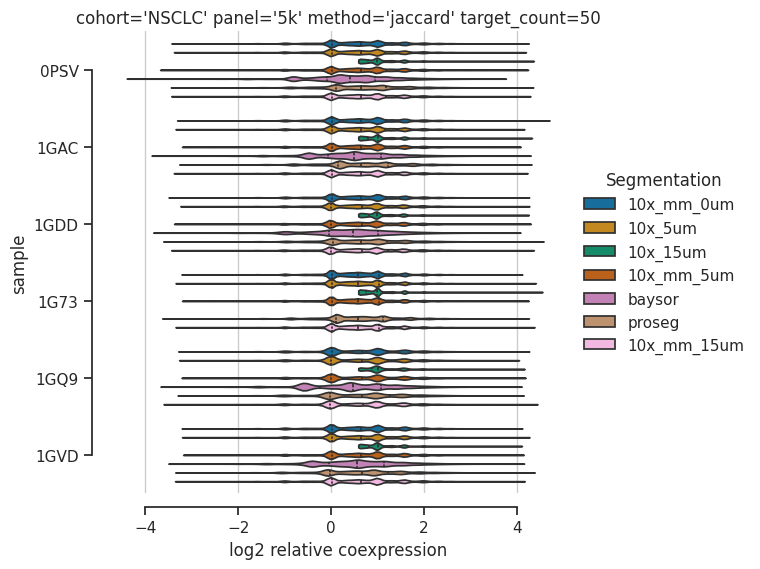

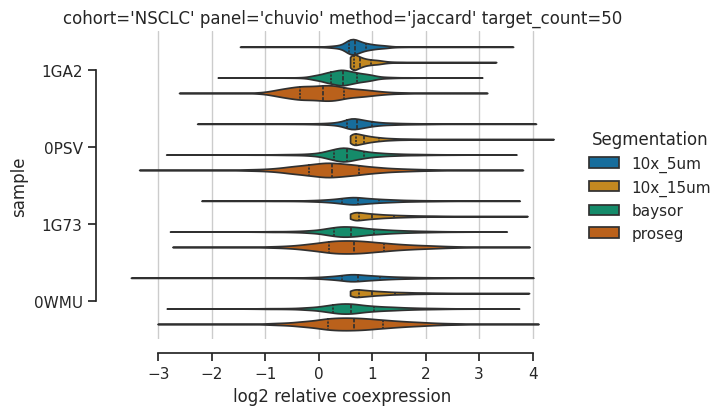

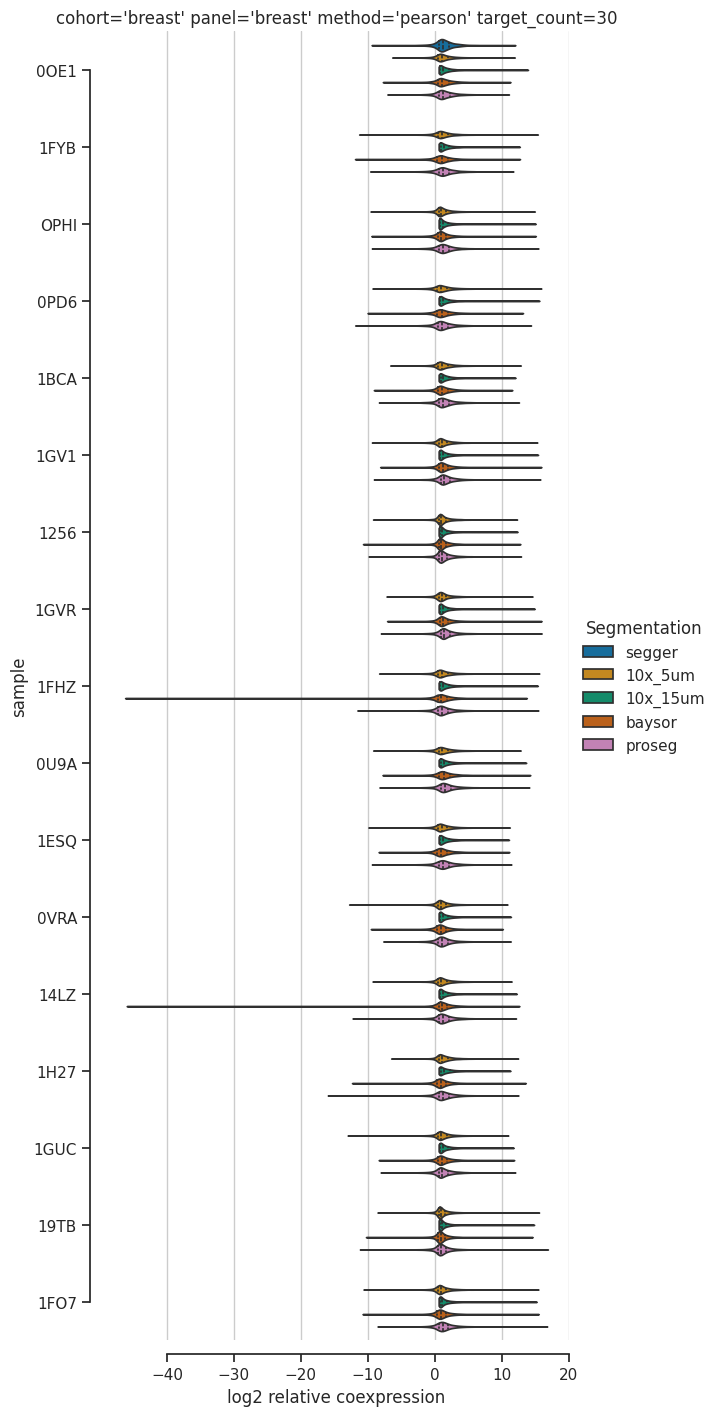

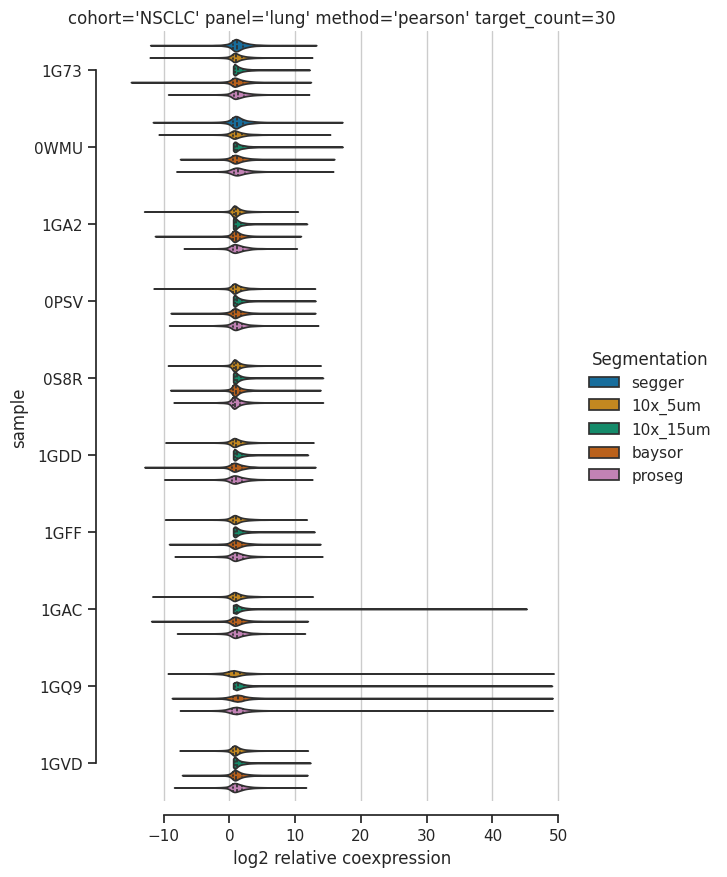

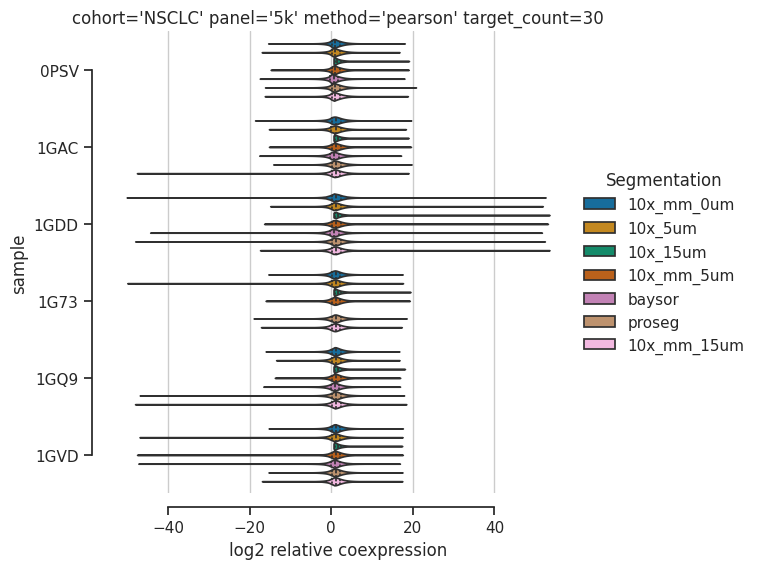

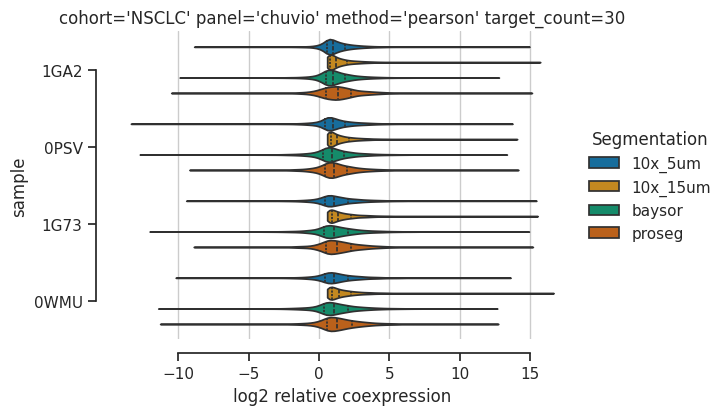

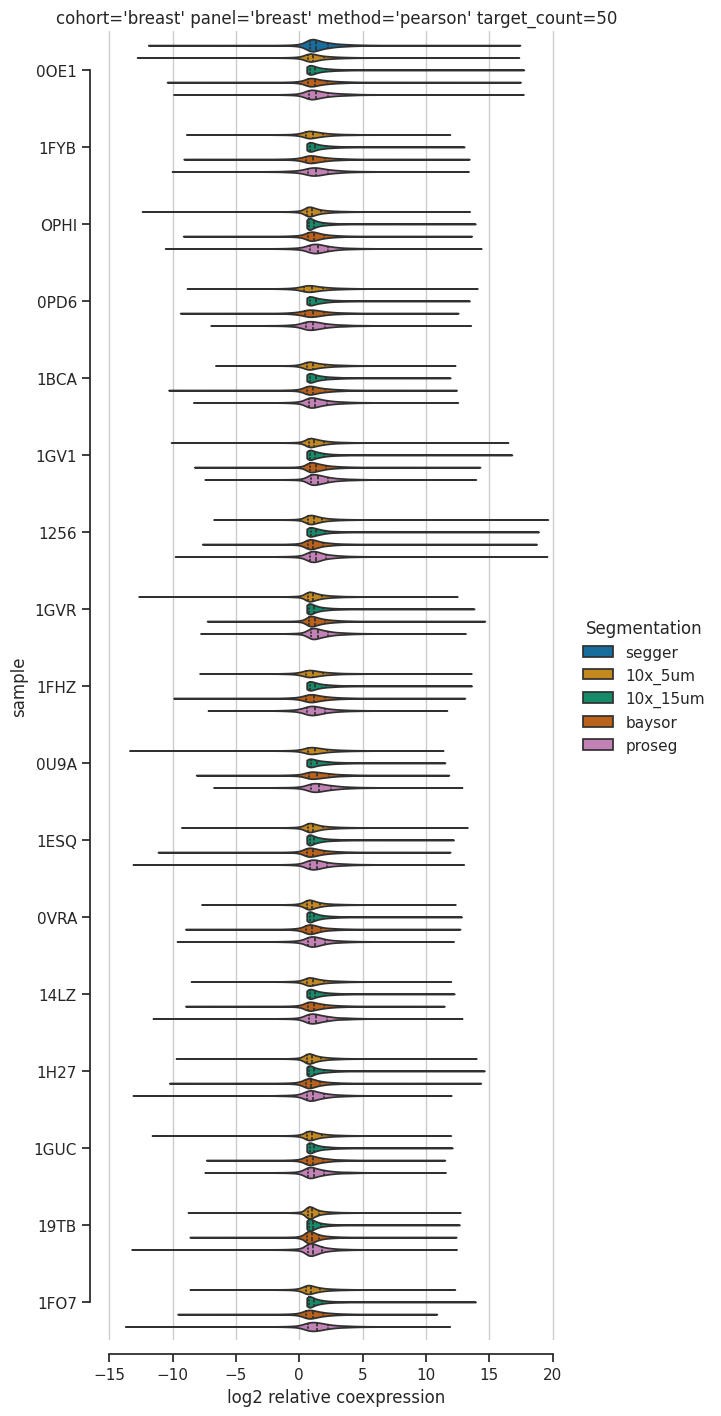

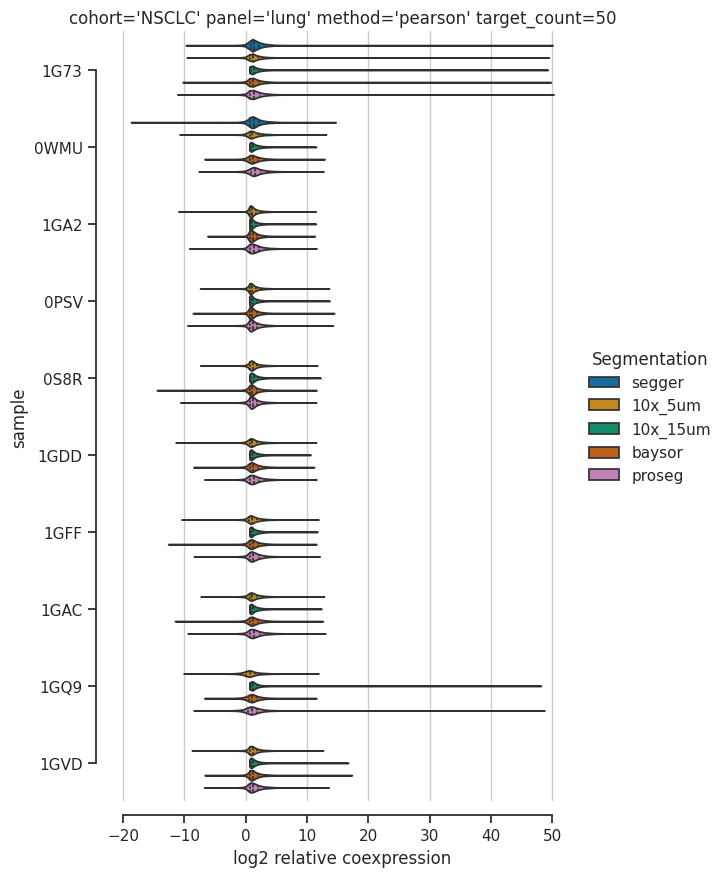

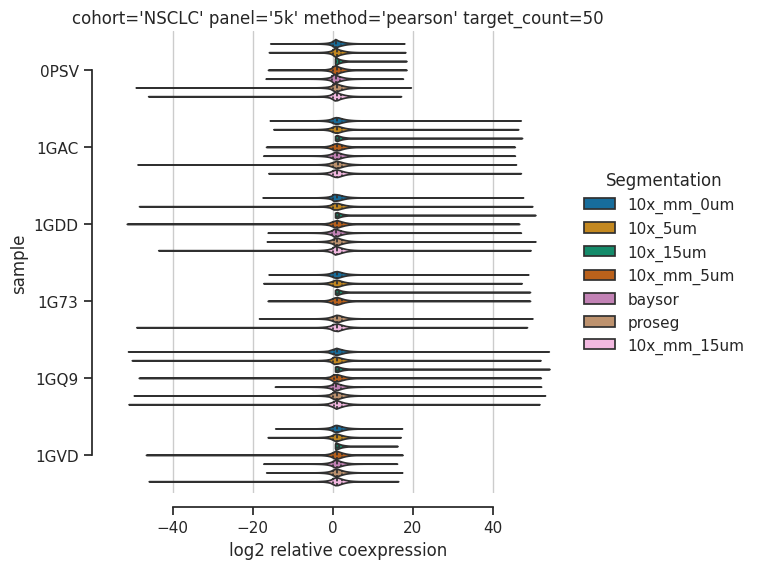

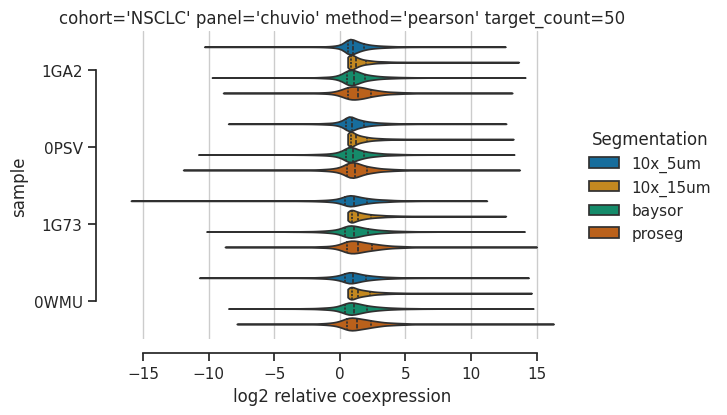

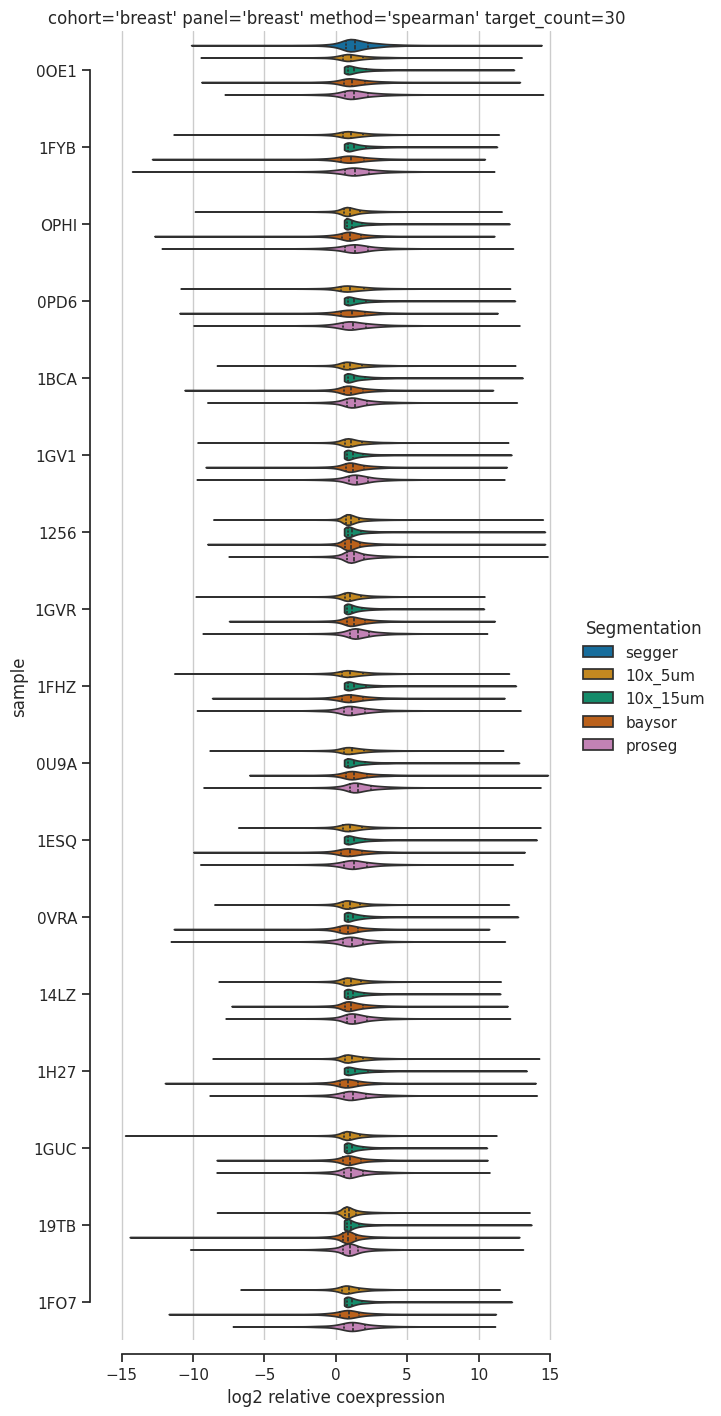

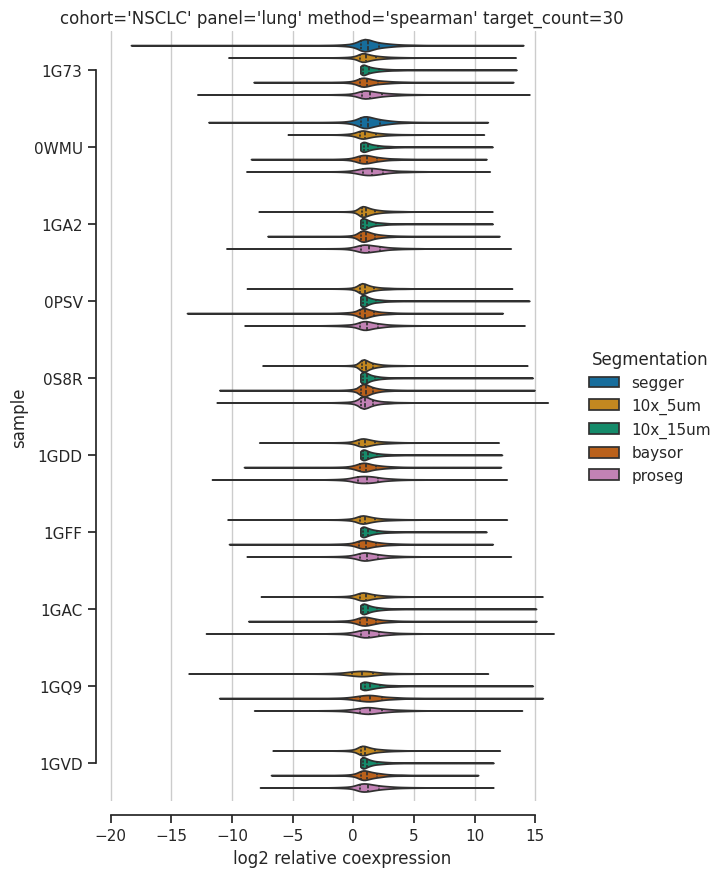

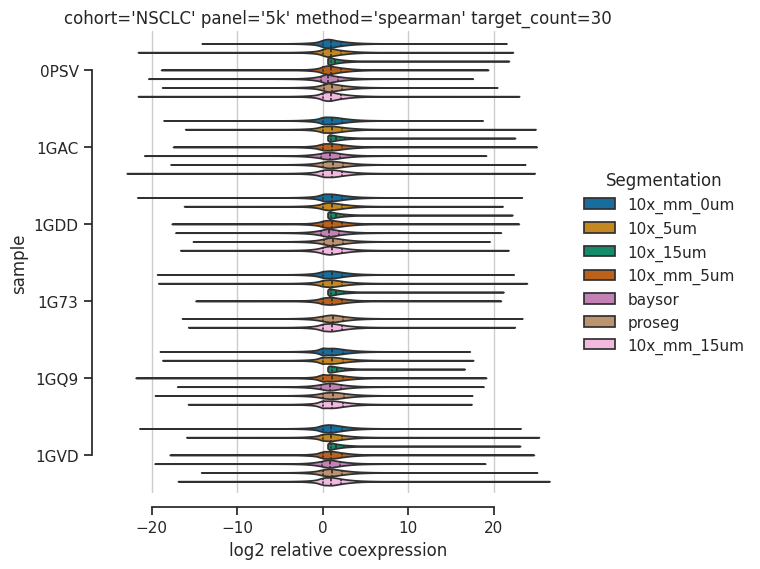

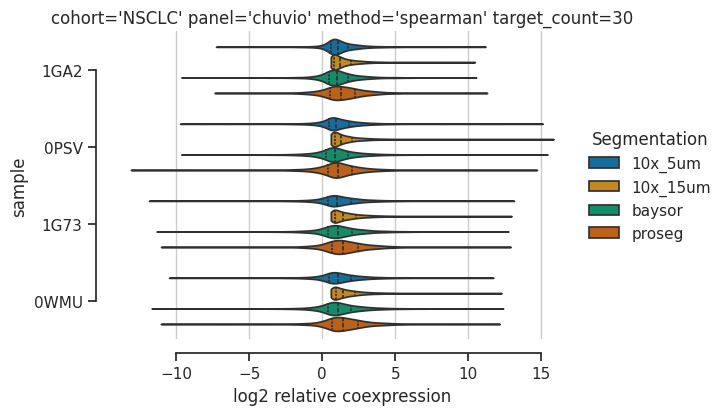

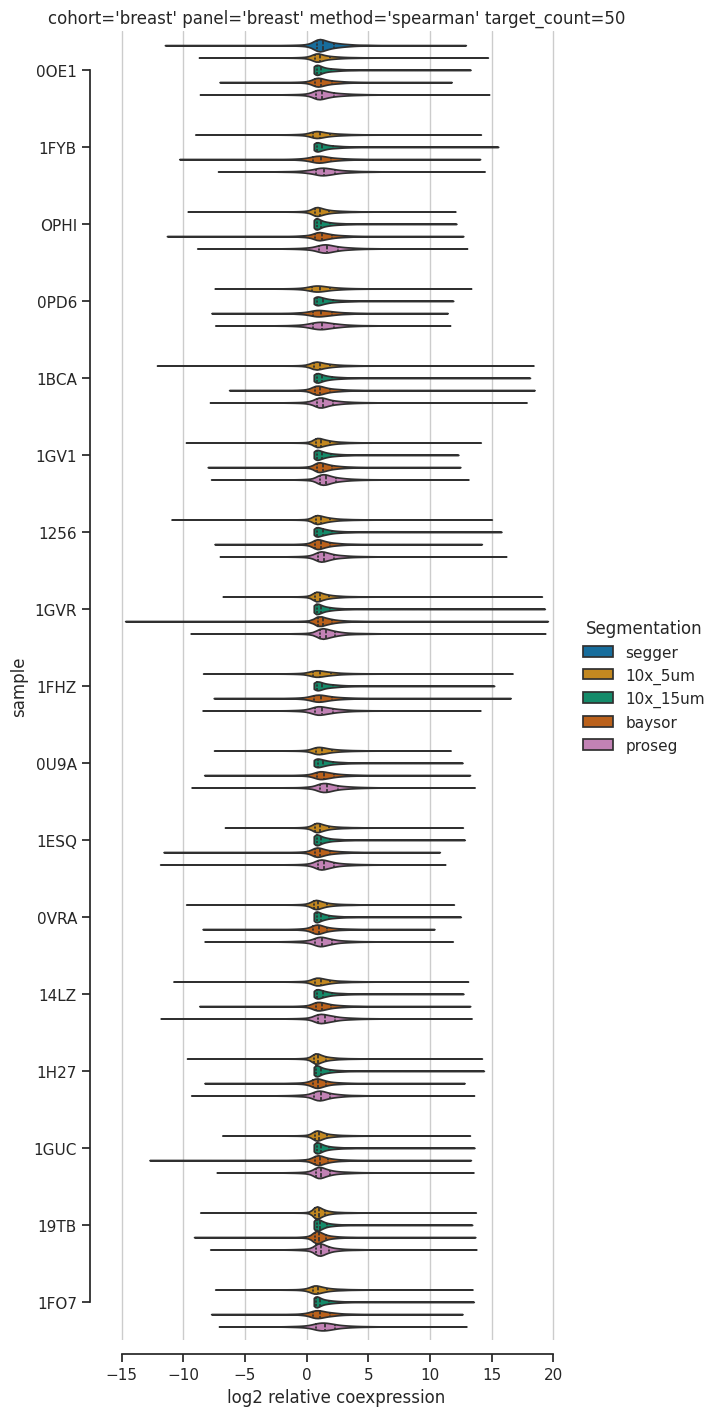

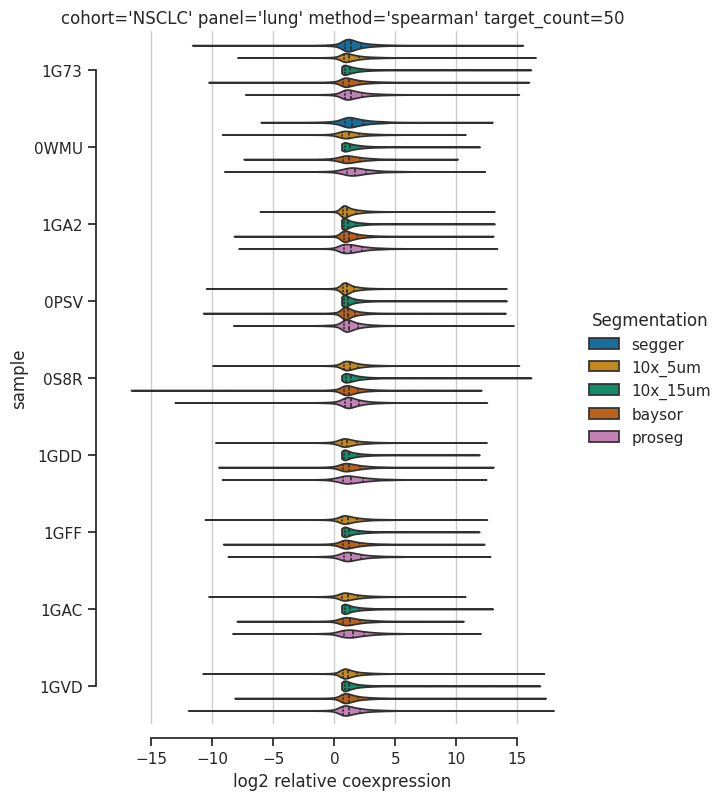

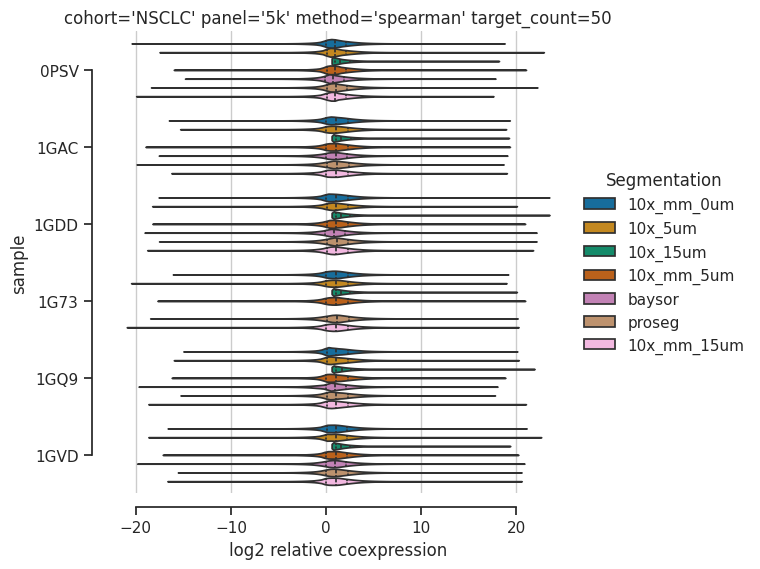

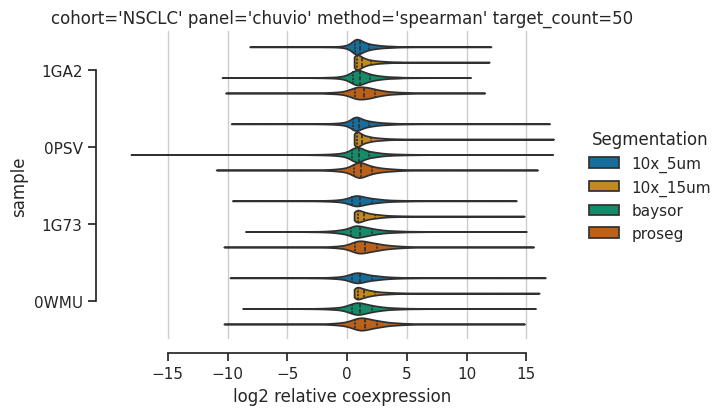

In [127]:
import warnings

method = 'jaccard'
target_count = 50
ref_oversegmentation = '10x_15um'
log2 = True
keys = pd.DataFrame(CCdiff.keys(),columns=xenium_levels)
cohort_panels = keys[['cohort','panel']].drop_duplicates()

for method in methods:
    for target_count in target_counts:
        for cohort,panel in cohort_panels.values:
            data = []
            for _,k in keys.iterrows():
                if (cohort == k['cohort'] and panel ==  k['panel']):
                    
                    k_ref_over = (ref_oversegmentation,*k[1:])

                    mat = CCdiff[*k][method,target_count].replace(1.,np.nan)
                    if log2:
                        with warnings.catch_warnings(action="ignore"):
                            mat = np.log2(mat)
                        
                    i = spurious_gene_pairs[k_ref_over][method,target_count][:,0]
                    j = spurious_gene_pairs[k_ref_over][method,target_count][:,1]
                    flat_values = mat.values[mat.index.get_indexer(i), mat.columns.get_indexer(j)] 
                    data.extend(np.hstack((np.tile(k,(len(i),1)),flat_values[:,None])))

            # Convert to DataFrame for easier plotting
            df = pd.DataFrame(data, columns=xenium_levels+('log2 relative coexpression',))
            df['log2 relative coexpression']=df['log2 relative coexpression'].astype(float)

            # Create joint boxplot
            sns.set(style="ticks",palette='colorblind')
            plt.figure(figsize=(6, df['sample'].nunique()))
            g = sns.violinplot(data=df, x="log2 relative coexpression", y="sample", hue='segmentation', cut=0, width=.8,inner='quart')

            plt.title(f"{cohort=} {panel=} {method=} {target_count=}")
            # plt.axvline(0,c='k',linestyle='-',zorder=0,alpha=.3)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Segmentation', frameon=False)
            sns.despine(offset=10, trim=True)
            plt.gca().xaxis.grid(True) 
            plt.savefig(cfg['figures_dir'] + f"{cohort=} {panel=} {method=} {target_count=}.png",dpi=300,bbox_inches='tight')
            plt.show()

In [ ]:
marker_genes_idx = sd1.var_names.isin(u_markers_panel)
pos_nuc_markers = pos_nuc[:,marker_genes_idx]

CC_cells = coexpression.coexpression_cells(pos_nuc)
CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
plt.hist(CC_cells_sum,bins=50)
plt.show()

sd1.obs.loc[mask_nuc,'CC_cells_sum'] = CC_cells_sum

sc.set_figure_params(figsize=(15,15))
sc.pl.spatial(sd1[mask_nuc],spot_size=15,color='CC_cells_sum',cmap='viridis',vmax=50)
sc.pl.spatial(sd1[mask_nuc],spot_size=15,color='total_counts',cmap='viridis',vmax=150)

plt.scatter(sd1[mask_nuc].obs['total_counts'],sd1[mask_nuc].obs['CC_cells_sum'],alpha=.5)
np.corrcoef(sd1[mask_nuc].obs['total_counts'],sd1[mask_nuc].obs['CC_cells_sum'])[0,1]

## Find coexpressed and spurious genes scRNA

In [ ]:
ad = sc.read(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
ad_panel = ad[:,[g for g in sd1.var_names if g in ad.var_names]]

# compute CC
CCnuc_found = CCnuc.loc[ad_panel.var_names,ad_panel.var_names]
CCnuc_sc, Xnuc_downsampled_sc, pos_nuc_sc, pos_rate_nuc_sc, mask_nuc_sc = coexpression.coexpression(ad_panel,return_all=1)
CCdiff_sc, spurious_gene_pairs_sc = coexpression.compare_segmentations(pos_rate_nuc_sc, pos_rate_nuc, CCnuc_sc, CCnuc_found, min_positivity_rate=0.01,cc_cutoff = 2)
spurious_genes_idx_sc = np.unique(np.where(spurious_gene_pairs_sc))
spurious_genes_sc = ad_panel.var_names[spurious_genes_idx_sc]
spurious_genes_markers_sc = df_markers_panel.loc[df_markers_panel['canonical'].isin(spurious_genes_sc),'canonical'].unique()

print(len(spurious_genes_markers_sc), 'marker genes /', len(spurious_genes_sc),'spurious panel genes found')

# plot
sns.set(font_scale=.8)
# sns.clustermap(CCnuc.loc[spurious_genes,spurious_genes],yticklabels=True,xticklabels=True,figsize=(10,10))
sns.clustermap(CCdiff_sc.loc[spurious_genes_markers_sc,spurious_genes_markers_sc],
    yticklabels=True,xticklabels=True,figsize=(15,15),vmin=None,vmax=4,cmap='RdBu_r',center=1)
plt.show()

df_ct_markers_cc_nuc_sc, df_cc_melt_nuc_sc = coexpression.coexpression_by_cell_type(CCnuc_sc,spurious_genes_markers_sc,df_markers_panel)
sns.heatmap(df_ct_markers_cc,cmap='Purples')
plt.show()

df_ct_markers_cc_diff_sc, df_cc_melt_diff_sc = coexpression.coexpression_by_cell_type(CCdiff_sc,spurious_genes_markers_sc,df_markers_panel)
sns.heatmap(df_ct_markers_cc,cmap='RdBu_r',center=1)
plt.show()

In [ ]:
## 
df_markers_panel_ct = df_markers_panel.set_index("canonical")
df_cc_melt = df_cc_melt_nuc_sc.copy()
df_cc_melt['ct_genei'] = ''
df_cc_melt['ct_genej'] = ''
for i, row in df_cc_melt.iterrows():
    ct_genei = df_markers_panel_ct.loc[row["genei"], "index"]
    ct_genej = df_markers_panel_ct.loc[row["genej"], "index"]

    if isinstance(ct_genei, str):
        ct_genei = [ct_genei]
    if isinstance(ct_genej, str):
        ct_genej = [ct_genej]
    df_cc_melt.loc[df_cc_melt["genei"] == row["genei"],'ct_genei'] = ' & '.join(ct_genei) 
    df_cc_melt.loc[df_cc_melt["genej"] == row["genej"],'ct_genej'] = ' & '.join(ct_genej)

display(df_cc_melt[:20])

## Coexpression based on computational marker genes

### Estimate genes coexpression from scRNA

In [ ]:
# load doublets
# result = pyreadr.read_r('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/dbuszta/meso/processed_data/new_data/doublets_by_sample.rds')[None]

# load data
ad_sc = sc.read_h5ad(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
# ad_sc.obs['doublet_status'] = result.iloc[:,0]
# ad_sc = ad_sc[ad_sc.obs['doublet_status']=='singlet']
# ad_sc.obs = ad_sc.obs.join(pd.read_csv(cfg['results_dir']+'annotation/cell_type_annotation.csv',index_col=0))

# filter to xenium genes
xenium_panel_genes = pd.read_csv(cfg['data_dir']+'xenium_chuvio_panel_genes.csv',index_col=0)['0']
ad_sc_panel = ad_sc[:,ad_sc.var_names.isin(xenium_panel_genes)]

CT_KEY = 'cell_type_harmonized_level2_consensus'
u_cell_types = ad_sc_panel.obs[CT_KEY].unique()

# get df with max fraction for each cell type
(df_fraction,df_difference, 
df_max_difference) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 1., threshold_diff = 0.)
df_difference_sorted = df_difference[df_difference.max().sort_values().index]

# get df with thresholded max fraction for each cell type
(_,df_difference_thresholded, 
 df_max_difference_thresholded) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 0.01, threshold_diff = 0.25)
df_difference_thresholded_sorted = df_difference_thresholded[df_difference_thresholded.max().sort_values().index]

for df_difference_sorted_, df_max_difference_ in zip([df_difference_sorted,df_difference_thresholded_sorted],
                                                     [df_max_difference,df_max_difference_thresholded]):

    ### Boxplots
    plt.figure(figsize=(8,30))

    flierprops = dict(marker='o', markersize=1, linestyle='none', markerfacecolor='black')
    ax = sns.boxplot(data=df_difference_sorted_, orient='h', flierprops=flierprops)

    # Loop over columns to find and highlight max fliers
    for i, col in enumerate(df_difference_sorted_.columns):
        data = df_difference_sorted_[col]
        max_val = data.max()  # Find maximum value in the column
        ax.scatter(max_val,i, color='red', edgecolor='black', zorder=5, s=20)

    plt.title("Difference in % of cells expressing")
    plt.show()

    ### Heatmap
    sns.heatmap(df_max_difference_)

# Define markers
df_markers_scores = pd.DataFrame(index=ad_sc_panel.var_names,columns=u_cell_types)

for cti in u_cell_types:
    cti_columns = df_difference_thresholded.columns.str.split("_").str[0] == cti

    df_markers_scores[cti] = df_difference_thresholded.loc[:,cti_columns].mean(1)

ct_markers = {}
for ct in u_cell_types:
    ct_scores = df_markers_scores[ct].sort_values(ascending=False).dropna()
    markers_ = list(ct_scores[(ct_scores>0.)][:10].index)

    if len(markers_) > 0:
        ct_markers[ct] = markers_

df_markers_computational = pd.DataFrame([
    {"index": k, "canonical": v}
    for k, values in ct_markers.items()
    for v in values
])

### Coexpression

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

normalized_entropy_computational = {}
CC_computational = {}
CC_cells_sum_normalized_computational = {}

for segmentation in SEGMENTATIONS:

    normalized_entropy_computational[segmentation] = {}
    CC_computational[segmentation] = {}
    CC_cells_sum_normalized_computational[segmentation] = {}
        
    for k,ad_ in ads[segmentation].items():
        print(k)

        ad = ad_[ad_.uns[rctd_weights_key].index]

        ### Entropy
        W = ad.uns[rctd_weights_key].copy()
        W[W<0] = 0.
        W = sklearn.preprocessing.normalize(W,axis=0,norm='l1')
        normalized_entropy_computational[segmentation][k] = scipy.stats.entropy(W,axis=1)/np.log(W.shape[1])

        ### Coexpression
        # compute CC
        CC, X_downsampled, pos, pos_rate, mask = coexpression.coexpression(ad,target_count=30,method='jaccard')
        CC_computational[segmentation][k] = CC

        # load markers
        # df_markers_computational_panel = df_markers_computational[df_markers_computational['canonical'].isin(ad.var_names)]
        # u_markers_panel = df_markers_computational_panel['canonical'].unique()
        # marker_genes_idx = ad.var_names.isin(u_markers_panel)
        # print(len(u_markers_panel), 'marker genes /', ad.shape[1],'panel genes found')

        # df_ct_markers_cc = coexpression.coexpression_by_cell_type(CC,u_markers_panel,df_markers_computational_panel)
#         CC_cells = coexpression.coexpression_cells(pos)
#         CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
#         CC_cells_sum_normalized_computational[k] = np.array(CC_cells_sum)/(marker_genes_idx.sum()**2)
#         break

# palette = {'singlet':'green','doublet_certain':'blue','doublet_uncertain':'orange','reject':'red'}
# for segmentation in SEGMENTATIONS[:1]:
#     for k,ad_ in ads[segmentation].items():
#         ad = ad_[ad_.uns[rctd_weights_key].index]

#         g = sns.jointplot(x=normalized_entropy_computational[k], y=CC_cells_sum_normalized_computational[k], palette=palette,hue=ad.obs['spot_class_FLEX_original'],kind="scatter", height=5,s=8,alpha=.3)
#         g.set_axis_labels(f'{k} - normalized RCTD weights normalized entropy', f'{k} - normalized coexpression score')
#         plt.show()
#         break

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

# Define a function for processing one (segmentation, k) pair
def process_task(segmentation, k, ad_, rctd_weights_key):
    print(f"Processing {segmentation}, {k}")

    # Filter data
    ad = ad_[ad_.uns[rctd_weights_key].index]

    # Entropy computation
    W = ad.uns[rctd_weights_key].copy()
    W[W < 0] = 0.0
    W = sklearn.preprocessing.normalize(W, axis=0, norm='l1')
    normalized_entropy = scipy.stats.entropy(W, axis=1) / np.log(W.shape[1])

    # Coexpression computation
    CC, X_downsampled, pos, pos_rate, mask = coexpression.coexpression(ad, target_count=30, method='jaccard')

    return segmentation, k, normalized_entropy, CC

# Prepare the tasks
tasks = []
for segmentation in SEGMENTATIONS:
    for k, ad_ in ads[segmentation].items():
        tasks.append((segmentation, k, ad_, rctd_weights_key))

# Run tasks in parallel
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_task)(segmentation, k, ad_, rctd_weights_key) for segmentation, k, ad_, rctd_weights_key in tasks
)

# Collect results
normalized_entropy_computational = {seg: {} for seg in SEGMENTATIONS}
CC_computational = {seg: {} for seg in SEGMENTATIONS}

for segmentation, k, entropy, CC in results:
    normalized_entropy_computational[segmentation][k] = entropy
    CC_computational[segmentation][k] = CC


In [ ]:
sample = '16MD_run14'
coexpr_scores = pd.DataFrame()
normalized_entropy_computational_scores = pd.DataFrame()
for segmentation,CC_segmentations in CC_computational.items():
    for sample, CC_sample in CC_segmentations.items():
        coexpr_scores.loc[segmentation,sample] = CC_sample.values[np.triu_indices_from(CC_sample,1)].sum()
        normalized_entropy_computational_scores.loc[segmentation,sample] = normalized_entropy_computational[segmentation][sample].sum()

sns.clustermap(coexpr_scores.fillna(coexpr_scores.mean()),figsize=(10,5),cmap='Reds')

coexpr_scores_norm = coexpr_scores.fillna(coexpr_scores.mean())
sns.clustermap(coexpr_scores_norm/coexpr_scores_norm.max(),figsize=(10,5),cmap='Reds')

sns.clustermap(normalized_entropy_computational_scores,figsize=(10,5),cmap='Reds')
sns.clustermap(normalized_entropy_computational_scores/normalized_entropy_computational_scores.max(),figsize=(10,5),cmap='Reds')

In [ ]:
median_transcripts_per_cell = pd.DataFrame()
for segmentation, ads_seg in ads.items():
    for sample, ad in ads_seg.items():
        median_transcripts_per_cell.loc[segmentation,sample] = ad.uns['metrics_summary'].loc[0,'median_transcripts_per_cell']

In [ ]:
df1 = normalized_entropy_computational_scores
df2 = coexpr_scores

plot_data = []
for idx in df1.index:
    for col in df1.columns:
        plot_data.append({
            'segmentation': idx,
            'samples': col,
            'normalized_entropy_computational_scores': df1.loc[idx, col],
            'coexpr_scores': df2.loc[idx, col]
        })

plot_df = pd.DataFrame(plot_data)

sns.boxplot(plot_df,x='segmentation',y='coexpr_scores');plt.show()
sns.boxplot(plot_df,x='segmentation',y='normalized_entropy_computational_scores')

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='normalized_entropy_computational_scores',  # x-axis: values from df1
    y='coexpr_scores',  # y-axis: values from df2
    hue='segmentation',  # color based on segmentation
    style='samples',  # marker type based on samples
    s=50  # marker size
)

# plt.title('Scatter Plot: df1 vs df2')
# plt.xlabel('Values from df1')
# plt.ylabel('Values from df2')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# Find universal markers
ad_sc_panel.var['n_cells'] = (ad_sc_panel.X>0).sum(0).A1
ad_sc_panel.var['n_cells'].hist(bins=100)
CC, X_downsampled, pos_, pos_rate_, mask_ = coexpression.coexpression(ad_sc_panel,target_count=None,min_cond_coex=0.)

threshold = 0.01
pos_rate_threshold = 0.01

valid_genes = np.where(pos_rate > pos_rate_threshold)[0]

gene_pairs_idx = np.vstack((CC.values<threshold).nonzero()).T
gene_pairs_idx_u = pd.DataFrame(gene_pairs_idx)
gene_pairs_idx_u['Key'] = gene_pairs_idx_u.apply(lambda row: tuple(sorted(row)), axis=1)
gene_pairs_idx_u = gene_pairs_idx_u.drop_duplicates(subset='Key').drop(columns='Key')
gene_pairs_idx_u = gene_pairs_idx_u[gene_pairs_idx_u.isin(valid_genes).sum(1)==2]
gene_pairs_idx_u = gene_pairs_idx_u.values
print(len(gene_pairs_idx_u))

# Score xenium samples per gene
# CC_computational_scores = {}
# for segmentation in SEGMENTATIONS:
#     for k,ad_ in ads[segmentation].items():
#         CC_computational_scores[segmentation][k] = CC_computational[segmentation][k].values[gene_pairs_idx_u[:,0],gene_pairs_idx_u[:,1]].sum(1)

# Score xenium samples per cell
# CC_cells_score = coexpression.coexpression_cells_score_gene_pairs(CC_cells, gene_pairs_idx_u)

# ad.obs['CC_cells_score'] = CC_cells_score
# ad.obs['CC_cells_score'].hist(bins=100)

# sc.set_figure_params(figsize=(10,10))
# sc.pl.spatial(ad,color='CC_cells_score',spot_size=10,)
# (ad.obs['CC_cells_score']>0).sum()